# MODIS MCD43产品与MOD09产品地表反射率对比

## 1.1 环境准备

conda install -c conda-forge pyhdf  
conda install -c conda-forge gdal

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pyproj
import tkinter
from tkinter import  filedialog
import os
import fnmatch
from pyhdf.SD import SD
from osgeo import gdal
from ipywidgets import IntSlider, HTML, Box, interact
from datetime import datetime, timedelta
import h5py

## 1.2 核心函数定义

### 1.2.1 BRDF核函数

- 版本一：

In [2]:
def ross_thick(theta_i, theta_r, phi):
    """RossThick体散射核"""
    theta_i = np.deg2rad(theta_i)
    theta_r = np.deg2rad(theta_r)
    phi = np.deg2rad(phi)
    
    cos_xi = np.cos(theta_i)*np.cos(theta_r) + np.sin(theta_i)*np.sin(theta_r)*np.cos(phi)
    xi = np.arccos(np.clip(cos_xi, -1, 1))
    
    kernel = ((np.pi/2 - xi)*np.cos(xi) + np.sin(xi)) / (np.cos(theta_i) + np.cos(theta_r)) - np.pi/4
    return kernel

def li_sparse(theta_i, theta_r, phi):
    """LiSparseR几何光学核"""
    theta_i = np.deg2rad(theta_i)
    theta_r = np.deg2rad(theta_r)
    phi = np.deg2rad(phi)
    
    cos_xi = np.cos(theta_i)*np.cos(theta_r) + np.sin(theta_i)*np.sin(theta_r)*np.cos(phi)
    D = np.sqrt(np.tan(theta_i)**2 + np.tan(theta_r)**2 - 2*np.tan(theta_i)*np.tan(theta_r)*np.cos(phi))
    
    kernel = (1 + (1 + cos_xi)**-1) * (np.pi - D - np.sin(D)) / (4*np.cos(theta_i)*np.cos(theta_r))
    return kernel

- 版本二：

In [3]:
def ross_thick2(theta_i, theta_r, phi):
    theta_i = np.deg2rad(theta_i)
    theta_r = np.deg2rad(theta_r)
    phi = np.deg2rad(phi)
    cos_xi = np.cos(theta_i)*np.cos(theta_r) + np.sin(theta_i)*np.sin(theta_r)*np.cos(phi)
    xi = np.arccos(np.clip(cos_xi, -1, 1))
    sin_xi = np.sin(xi);
    kernel = ((np.pi/2 - xi)*cos_xi + sin_xi) / (np.cos(theta_i) + np.cos(theta_r)) - np.pi/4
    return kernel

def li_sparse2(theta_i, theta_r, phi):
    theta_i = np.deg2rad(theta_i)
    theta_r = np.deg2rad(theta_r)
    phi = np.deg2rad(phi)
    HB = 2; BR = 1
    tanvp = BR*np.tan(theta_r)
    if tanvp <= 0:tanvp = 0.0
    angp = np.arctan(tanvp); sinvp = np.sin(angp); cosvp = np.cos(angp)
    tanip = BR*np.tan(theta_i)
    if tanip <= 0:tanip = 0.0
    angp = np.arctan(tanip); sinip = np.sin(angp); cosip = np.cos(angp)
    cosphi = np.cos(phi)
    sinphi = np.sin(phi)
    cosphaangp = cosvp*cosip + sinvp*sinip*cosphi
    phaangp = np.acos(np.clip(cosphaangp,-1,1))
    sinphaangp = np.sin(phaangp)
    temp1 = tanvp*tanvp+tanip*tanip-2.0*tanvp*tanip*cosphi
    distancep = np.sqrt(np.max([0.0,temp1]))
    temp2 = 1.0/cosvp + 1.0/cosip
    cost = HB*np.sqrt(distancep*distancep+tanvp*tanvp*tanip*tanip*sinphi*sinphi)/temp2
    cost = np.clip(cost, -1, 1)
    tvar = np.acos(cost)
    sint = np.sin(tvar)
    overlap = 1.0/np.pi *(tvar-sint*cost)*temp2
    overlap = np.max([0.0,overlap])
    kernel = overlap - temp2 + 0.5 * (1.0 + cosphaangp)/cosvp/cosip
    return kernel

### 1.2.2 反射率模拟函数

- 版本一：

In [4]:
def simulate_refl(f_iso, f_vol, f_geo, sza, vza, raa):
    """
    计算指定几何条件下的反射率
    Args:
        sza: 太阳天顶角（度）
        vza: 观测天顶角（度）
        raa: 相对方位角（度）
    Returns:
        模拟反射率矩阵
    """
    k_vol = ross_thick(sza, vza, raa)
    k_geo = li_sparse(sza, vza, raa)
    return f_iso + f_vol*k_vol + f_geo*k_geo,k_vol,k_geo

- 版本二

In [5]:
def simulate_refl2(f_iso, f_vol, f_geo, sza, vza, raa):
    """
    计算指定几何条件下的反射率
    Args:
        sza: 太阳天顶角（度）
        vza: 观测天顶角（度）
        raa: 相对方位角（度）
    Returns:
        模拟反射率矩阵
    """
    k_vol = ross_thick2(sza, vza, raa)
    k_geo = li_sparse2(sza, vza, raa)
    return f_iso + f_vol*k_vol + f_geo*k_geo,k_vol,k_geo

### 1.2.3 读取MCD43A1 BRDF参数

In [6]:
def read_mcd43a1_point(hdf5_name,sd_list,lon,lat,band_number=1):
    gdal.UseExceptions()
    # 打开HDF文件
    hdf_ds = gdal.Open(hdf5_name)
    if hdf_ds is None:
        raise ValueError("无法打开HDF文件")
    else:
        # print("...正在处理" + hdf5_name) 
        pass
    # 获取子数据集列表
    subdatasets = hdf_ds.GetSubDatasets()
    # print(subdatasets)

    subdatasets_simple_array =np.array([])
    subdatasets_full_array =np.array([])
    for subdataset in subdatasets:
        subdatasets_simple_array = np.append(subdatasets_simple_array,subdataset[1])
        subdatasets_full_array = np.append(subdatasets_full_array,subdataset[0])
    # print(subdatasets_array)
    flag = 0#计数器
    for sd_name in sd_list:
        sd_full_name = f"BRDF_Albedo_Parameters_Band{band_number}"
        # 使用列表推导式找到包含子字符串的元素的索引
        ind = [i for i, s in enumerate(subdatasets_simple_array) if sd_full_name in s]
        # print(subdatasets_simple_array[ind[0]])
        # 打开选定的子数据集
        sds_ds = gdal.Open(subdatasets_full_array[ind[0]])
        # 获取地理变换参数和投影
        geotransform = sds_ds.GetGeoTransform()
        projection = sds_ds.GetProjection()
        # 创建坐标转换器
        crs = pyproj.CRS.from_wkt(projection)
        transformer = pyproj.Transformer.from_crs('EPSG:4326', crs, always_xy=True)       
        # 转换经纬度到投影坐标
        x, y = transformer.transform(lon, lat)
        # print([x,y])
        # 计算行列号
        x_origin, x_pixel = geotransform[0], geotransform[1]
        y_origin, y_pixel = geotransform[3], geotransform[5]
        col = int((x - x_origin) / x_pixel)
        row = int((y - y_origin) / y_pixel)
        if flag==0:# 统计第一个数据集的就可以，其他数据集都一样
            # 像素中心的实际行和列索引（从0开始）
            # 由于像素中心在相邻像素的边界上，我们需要对行和列索引进行调整
            center_row = row + 0.5
            center_col = col + 0.5
            # 使用地理变换参数将像素中心的行列索引转换为地理坐标
            center_x = geotransform[0] + center_col * geotransform[1] + center_row * geotransform[2]
            center_y = geotransform[3] + center_col * geotransform[4] + center_row * geotransform[5]
            distance = np.sqrt((x - center_x)**2+(y-center_y)**2)/1000.0#单位是km
            # 创建从sinusoidal投影到WGS 84（EPSG:4326）的转换器
            # 注意：这里我们交换了源CRS和目标CRS的顺序
            reverse_transformer = pyproj.Transformer.from_crs(crs, 'EPSG:4326', always_xy=True)
            # 将x, y坐标转换回经纬度坐标
            center_lon, center_lat = reverse_transformer.transform(center_x, center_y)
            sd_array = np.array([lon, lat, col, row, distance, center_lon, center_lat])#保存数据
        # 读取数据并提取值
        band1 = sds_ds.GetRasterBand(1)
        band2 = sds_ds.GetRasterBand(2)
        band3 = sds_ds.GetRasterBand(3)
        # 获取元数据字典（键值对）
        metadata = sds_ds.GetMetadata()
        # 提取特定属性（例如scale_factor）
        scale_factor = float(metadata.get("scale_factor", None))
        add_offset = float(metadata.get("add_offset", None))

        f_iso = band1.ReadAsArray()
        f_vol = band2.ReadAsArray()
        f_geo = band3.ReadAsArray()

        # 验证行列号范围
        rows, cols = f_iso.shape
        if 0 <= row < rows and 0 <= col < cols:
            f_iso_value = f_iso[row, col].item()#转换为Python标量
            f_vol_value = f_vol[row, col].item()#转换为Python标量
            f_geo_value = f_geo[row, col].item()#转换为Python标量
            sd_array = np.append(sd_array, f_iso_value*scale_factor + add_offset)
            sd_array = np.append(sd_array, f_vol_value*scale_factor + add_offset)
            sd_array = np.append(sd_array, f_geo_value*scale_factor + add_offset)
        else:
            f_iso_value = None
            f_vol_value = None
            f_geo_value = None
        # 关闭数据集
        sds_ds = None
        # 计数器数值更新
        flag+=1
    hdf_ds = None
    #单波段
    #经度，纬度，行号，列号，距离，像元经度，像元纬度，参数1，参数2，参数3
    return sd_array


### 1.2.4 读取MOD03 观测几何参数

In [7]:
'''给定一个经纬度值从MOD03中提取数据'''
def read_mod03_point(hdf4_name, lonlat_list, sd_list, x,y):
    f = SD(hdf4_name);
    Lon = np.array(f.select(lonlat_list[0]), dtype=np.float64)#得到经度数据集
    Lat = np.array(f.select(lonlat_list[1]), dtype=np.float64)#得到纬度数据集
    C = np.sin((90-y)*np.pi/180)*np.sin((90-Lat)*np.pi/180)*np.cos(
        (x - Lon)*np.pi/180) + np.cos((90-y)*np.pi/180)*np.cos((90-Lat)*np.pi/180)
    R = 6371.0; distance = R*np.arccos(C)#*np.pi/180#单位：km
    ind = np.where(distance == np.min(distance))#得到对应行列号元组
    index = ind#复制产生新元组
    if np.size(index) > 2:
        index = (index[0])#当存在多个符合条件像元时
    sd_array = np.array([x, y, index[0][0],index[1][0],
                         distance[index[0][0],index[1][0]],Lon[index[0][0],index[1][0]],Lat[index[0][0],index[1][0]]])#保存数据
    for sd_name in sd_list:
        sd_data =  np.array(f.select(sd_name), dtype=np.float64)#得到数据集
        scale_factor = getattr(f.select(sd_name),'scale_factor',1)
        add_offset = getattr(f.select(sd_name),'add_offset',0)      
        if sd_data.ndim == 1:#一维数据
            sd_array = np.append(sd_array, sd_data[index[0][0]]*scale_factor + add_offset)
        elif sd_data.ndim == 2:#二维数据
            sd_array = np.append(sd_array, sd_data[index[0][0],index[1][0]]*scale_factor + add_offset)
    f.end()
    # 利用masked_where进行掩膜，可使统计时忽略无效值
    # refl = np.ma.masked_where(refl > 1.0, refl)
    # sd_array = np.append(sd_array, "")
    return sd_array

### 1.2.5 读取MOD09 L2级地表反射率数据

In [8]:
'''给定一个经纬度值从MOD09中提取数据'''
def read_mod09_point(hdf4_name, lonlat_list, sd_list, x,y):
    f = SD(hdf4_name);
    Lon = np.array(f.select(lonlat_list[0]), dtype=np.float64)#得到经度数据集
    Lat = np.array(f.select(lonlat_list[1]), dtype=np.float64)#得到纬度数据集
    C = np.sin((90-y)*np.pi/180)*np.sin((90-Lat)*np.pi/180)*np.cos(
        (x - Lon)*np.pi/180) + np.cos((90-y)*np.pi/180)*np.cos((90-Lat)*np.pi/180)
    R = 6371.0; distance = R*np.arccos(C)#*np.pi/180#单位：km
    ind = np.where(distance == np.min(distance))#得到对应行列号元组
    index = ind#复制产生新元组
    if np.size(index) > 2:
        index = (index[0])#当存在多个符合条件像元时
    sd_array = np.array([x, y, index[0][0],index[1][0],
                         distance[index[0][0],index[1][0]],Lon[index[0][0],index[1][0]],Lat[index[0][0],index[1][0]]])#保存数据
    for sd_name in sd_list:
        sd_data =  np.array(f.select(sd_name), dtype=np.float64)#得到数据集
        scale_factor = getattr(f.select(sd_name),'scale_factor')
        add_offset = getattr(f.select(sd_name),'add_offset')
        if sd_data.ndim == 1:#一维数据
            sd_array = np.append(sd_array, sd_data[index[0][0]]*scale_factor + add_offset)
        elif sd_data.ndim == 2:#二维数据
            sd_array = np.append(sd_array, sd_data[index[0][0],index[1][0]]*scale_factor + add_offset)
    f.end()
    # 利用masked_where进行掩膜，可使统计时忽略无效值
    # refl = np.ma.masked_where(refl > 1.0, refl)
    # sd_array = np.append(sd_array, "")
    return sd_array

## 1.3 模拟与验证流程

### 1.3.1 配置数据文件路径

In [ ]:
root = tkinter.Tk(); root.withdraw()#实现主窗口隐藏
open_mod03_Name = filedialog.askopenfilename(title="指定一个MOD03文件")#启动浏览目录
# open_mcd43_Name = filedialog.askopenfilename(title="指定一个MCD43A1文件")#启动浏览目录
open_mcd43_path = filedialog.askdirectory(title="指定MCD43A1工作空间")#启动浏览目录
open_mod09_Name = filedialog.askopenfilename(title="指定一个MOD09文件")#启动浏览目录
root.destroy(); root.mainloop()#销毁GUI资源
FilePath = os.path.dirname(open_mod03_Name)

origin_path = os.chdir()
os.chdir(FilePath)#改变当前路径
print(os.getcwd())

D:\Users\LYU\Documents\PyScripts\PSG\BRDF\data\MODIS@Libya4\20240309


### 1.3.2 指定地面点位和数据集

In [17]:
Libya4=[23.39,28.55]#lon,lat
'''mod03数据集列表''' 
mod03_lonlat_list = ['Longitude','Latitude']
mod03_sd_list = ['SolarZenith','SensorZenith','SolarAzimuth','SensorAzimuth']
'''mod09数据集列表''' 
mod09_lonlat_list = ['Longitude','Latitude']
mod09_sd_list = [
    '1km Surface Reflectance Band 1','1km Surface Reflectance Band 2',
    '1km Surface Reflectance Band 3','1km Surface Reflectance Band 4',
    '1km Surface Reflectance Band 5','1km Surface Reflectance Band 6',
    '1km Surface Reflectance Band 7'
    ]
'''mcd43需要取值的列表'''
mcd43_sd_list = ['BRDF_Albedo_Parameters_Band']
'''mcd43选用波段数'''
band_count = 7 #MODIS前7个波段（需与MOD09对应）

### 1.3.3 数据提取操作

- 处理MOD03产品

In [18]:

#经度，纬度，行号，列号，距离，像元经度，像元纬度，SolarZenith，SensorZenith，SolarAzimuth，SensorAzimuth，RAA
mod03_array = read_mod03_point(open_mod03_Name, mod03_lonlat_list, mod03_sd_list, Libya4[0],Libya4[1])
print(mod03_array)

[ 2.33900000e+01  2.85500000e+01  1.25700000e+03  1.00000000e+03
  6.23186485e-01  2.33963280e+01  2.85507164e+01  3.48400000e+01
  2.93900000e+01 -1.40950000e+02  7.95000000e+01]


- 处理MOD09产品

In [19]:
#经度，纬度，行号，列号，距离，像元经度，像元纬度，Band1，Band2，Band3，Band4，Band5，Band6，Band7
mod09_array = read_mod09_point(open_mod09_Name, mod09_lonlat_list, mod09_sd_list, Libya4[0],Libya4[1])
print(mod09_array)

[ 2.33900000e+01  2.85500000e+01  1.25700000e+03  1.00000000e+03
  6.23186485e-01  2.33963280e+01  2.85507164e+01  4.70300000e-01
  5.73400000e-01  1.83200000e-01  3.32300000e-01  6.57300000e-01
 -2.86720000e+00  6.95100000e-01]


- 处理MCD43产品

In [20]:
mcd43a1_filename_array = np.array([])#记录文件名
mcd43a1_fullfileband_array = np.array([])#(文件数，波段数，参数)
# 遍历目录中的所有文件
for root, dirs, files in os.walk(open_mcd43_path):
    for filename in files:
        # 检查文件名是否包含 "MCD43" 字符串并且文件扩展名是 .hdf 或 .hdf5
        if fnmatch.fnmatch(filename, 'MCD43A1*.hdf') or fnmatch.fnmatch(filename, 'MCD43A1*.hdf5'):
            open_mcd43_Name = os.path.join(root, filename)
            print(f'Found file: {open_mcd43_Name}')
            mcd43a1_fullband_array = np.array([])
            mcd43a1_filename_array = np.append(mcd43a1_filename_array,filename)
            # 提取n个文件前7个波段的10个参数(7个常规参数+3个BRDF参数)，array_size:(n,7,10)
            for band_number in range(1,band_count+1):
                mcd43a1_array = read_mcd43a1_point(open_mcd43_Name,mcd43_sd_list, Libya4[0],Libya4[1],band_number)
                if np.size(mcd43a1_fullband_array) == 0:
                    mcd43a1_fullband_array = np.concatenate((mcd43a1_fullband_array, mcd43a1_array))
                elif np.ndim(mcd43a1_fullband_array) == 1:
                    mcd43a1_fullband_array = np.concatenate((mcd43a1_fullband_array[np.newaxis,:], mcd43a1_array[np.newaxis,:]))
                elif np.ndim(mcd43a1_fullband_array) == 2:
                    mcd43a1_fullband_array = np.concatenate((mcd43a1_fullband_array, mcd43a1_array[np.newaxis,:]))
            # 汇总每个MCD43A1文件的数据
            if np.size(mcd43a1_fullfileband_array) == 0:
                mcd43a1_fullfileband_array = mcd43a1_fullband_array.copy()
            elif np.ndim(mcd43a1_fullfileband_array) == 2:
                mcd43a1_fullfileband_array = np.concatenate((mcd43a1_fullfileband_array[np.newaxis,:,:], mcd43a1_fullband_array[np.newaxis,:,:]))
            elif np.ndim(mcd43a1_fullfileband_array) == 3:
                mcd43a1_fullfileband_array = np.concatenate((mcd43a1_fullfileband_array, mcd43a1_fullband_array[np.newaxis,:,:]))

Found file: D:/Users/LYU/Documents/PyScripts/PSG/BRDF/data/MODIS@Libya4/20240309\MCD43A1.A2024073.h20v06.061.2024085220235.hdf
Found file: D:/Users/LYU/Documents/PyScripts/PSG/BRDF/data/MODIS@Libya4/20240309\MCD43A1.A2024074.h20v06.061.2024085223552.hdf
Found file: D:/Users/LYU/Documents/PyScripts/PSG/BRDF/data/MODIS@Libya4/20240309\MCD43A1.A2024075.h20v06.061.2024093024120.hdf
Found file: D:/Users/LYU/Documents/PyScripts/PSG/BRDF/data/MODIS@Libya4/20240309\MCD43A1.A2024076.h20v06.061.2024093214749.hdf
Found file: D:/Users/LYU/Documents/PyScripts/PSG/BRDF/data/MODIS@Libya4/20240309\MCD43A1.A2024077.h20v06.061.2024093235351.hdf
Found file: D:/Users/LYU/Documents/PyScripts/PSG/BRDF/data/MODIS@Libya4/20240309\MCD43A1.A2024078.h20v06.061.2024094010605.hdf
Found file: D:/Users/LYU/Documents/PyScripts/PSG/BRDF/data/MODIS@Libya4/20240309\MCD43A1.A2024079.h20v06.061.2024094145927.hdf
Found file: D:/Users/LYU/Documents/PyScripts/PSG/BRDF/data/MODIS@Libya4/20240309\MCD43A1.A2024080.h20v06.061.20

### 1.3.4 数据汇总

In [25]:
# 输入参数设置
sza = mod03_array[7]  # 太阳天顶角（来自MOD03）
vza = mod03_array[8]  # 观测天顶角
saz = mod03_array[9]
vaz = mod03_array[10]
raa = (saz - vaz) % 360  # 相对方位角

file_count= mcd43a1_fullfileband_array.shape[0]
band_count= mcd43a1_fullfileband_array.shape[1]
para_count= 7 + band_count#前7个基本参数 + 波段数
mcd43_array = np.empty((file_count,para_count))
for i in range(file_count):
    temp_array = mcd43a1_fullfileband_array[i][0][:7] # 前7个基本参数
    for j in range(0,band_count):
        # Step 1: 读取MCD43A1数据
        f_iso = mcd43a1_fullfileband_array[i][j][7]
        f_vol = mcd43a1_fullfileband_array[i][j][8]
        f_geo = mcd43a1_fullfileband_array[i][j][9]
        # Step 2: 质量掩膜（仅保留最佳质量数据）
        # Step 3: 计算模拟反射率
        simulated,k_vol,k_geo = simulate_refl2(f_iso, f_vol, f_geo, sza, vza, raa)
        # print(simulated)
        temp_array = np.append(temp_array,simulated)
    mcd43_array[i,:] = temp_array
print(mcd43_array[0,:])
print(k_vol,k_geo)

[2.33900000e+01 2.85500000e+01 1.30000000e+02 3.47000000e+02
 3.23822123e-01 2.33881462e+01 2.85520833e+01 4.61426127e-01
 5.62414943e-01 1.80138314e-01 3.22975275e-01 6.19952907e-01
 6.96781042e-01 6.36468504e-01]
-0.11830492471156429 -1.3160923433093603


### 1.3.5 可视化

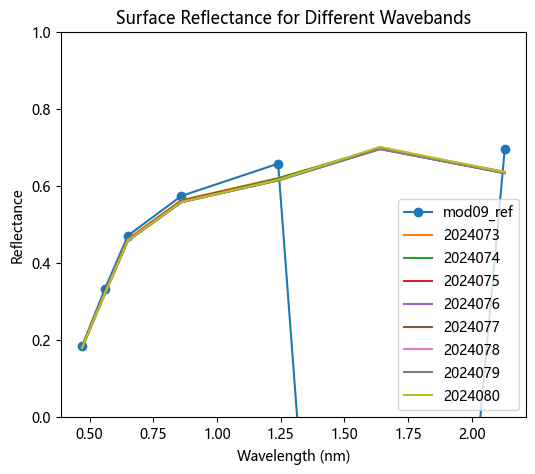

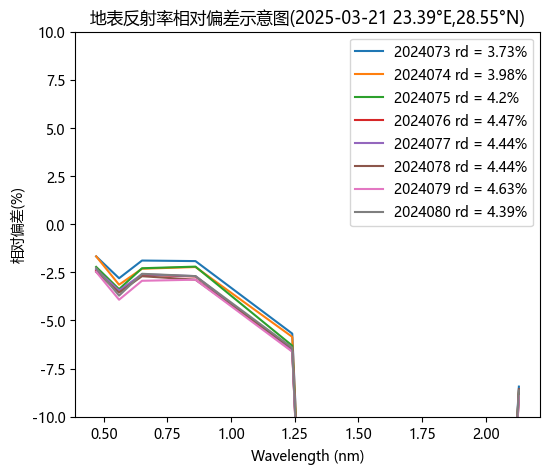

In [17]:
%matplotlib inline

# 配置 Matplotlib 使用中文字体（这里以 SimHei 为例，确保你的系统中有这个字体）
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']  # 指定默认字体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

plt.close('all')
mcd43_curves_name = np.array([curves_name[9:16] for curves_name in mcd43a1_filename_array])#记录文件名
wavelengths = [0.47, 0.56, 0.65, 0.86, 1.24, 1.64, 2.13]
mod09_ref = mod09_array[7:]
mod09_ref[[0,1,2,3]]=mod09_ref[[2,3,0,1]]#调整波段顺序
mcd43_ref_array = mcd43_array[:,7:]
# 图1
fig_1  = plt.figure(figsize=(6, 5))
mod09_ref_plot  = plt.plot(
    wavelengths, mod09_ref, label="mod09_ref", marker='o')
for i, curve in enumerate(mcd43_ref_array):
    curve[[0,1,2,3]]=curve[[2,3,0,1]]#调整波段顺序，curve是mcd43_ref_array的引用，因而会改变原始值
    plt.plot(wavelengths, curve, label=mcd43_curves_name[i])  # 使用curve_names[i]作为标签
plt.title('Surface Reflectance for Different Wavebands')
plt.xlabel("Wavelength (nm)") # add xlabel
plt.ylabel("Reflectance") # add ylabel 
plt.ylim(0.00, 1.00) # set y limits
# 添加图例
plt.legend()
# 图2
fig_2  = plt.figure(figsize=(6, 5))
# 求观测年积日2024080的具体年月日
start_date = datetime(2025, 1, 1);target_date = start_date + timedelta(days=80-1);obs_day_str = target_date.strftime('%Y-%m-%d')
ref_dif_array = (mcd43_ref_array - mod09_ref)/mod09_ref*100
for i, curve in enumerate(ref_dif_array):
    outlier_index = 5 # 1.64μm数值异常
    rd_str = "rd = " + str(round(np.mean(np.abs(np.delete(curve,outlier_index))),2)) + "%"#计算rd平均值
    plt.plot(wavelengths, curve, label=mcd43_curves_name[i]+" "+rd_str)# 使用curve_names[i]作为标签
lon, lat = Libya4;form_lon = f"{lon:.2f}°E";form_lat = f"{lat:.2f}°N";lonlat_str = f"{form_lon},{form_lat}"
plt.title('地表反射率相对偏差示意图('+obs_day_str+' '+lonlat_str+')')
plt.xlabel("Wavelength (nm)") # add xlabel
plt.ylabel("相对偏差(%)") # add ylabel
plt.ylim(-10, 10) # set y limits
# 添加图例
plt.legend()
 
# 显示图形
plt.show()

### 1.3.6 其他数据测试

In [ ]:
os.chdir(origin_path)
file_path = r"data/MCD43A1_BRDF_Parameters_QA1_Libya4_YY2008_2012_AVE.hdf5"
with h5py.File(file_path, 'r') as f:
    brdf_ave = f['DataFields/BRDF_Albedo_Parameters_ave'][:]
    point_Lat_Lon = f['DataFields/LatLon'][:]
# 验证数据形状是否符合预期
if brdf_ave.shape != (3, 7, 12):
    raise ValueError(f"数据形状{brdf_ave.shape}与预期形状(3, 7, 12)不符")
# 输入参数设置
month = 2 + 1 # 月份
sza = 30.0  # 太阳天顶角
vza = 30.0  # 观测天顶角
raa = 0.0  # 相对方位角

para_count= brdf_ave.shape[0]# 3
band_count= brdf_ave.shape[1]# 7
month_count= brdf_ave.shape[2]# 12

mcd43_array = np.empty((month_count,band_count))
for i in range(month_count):
    temp_array = np.array([])
    for j in range(0,band_count):
        # Step 1: 读取MCD43A1数据
        f_iso = brdf_ave[0][j][i]
        f_vol = brdf_ave[1][j][i]
        f_geo = brdf_ave[2][j][i]
        # Step 2: 质量掩膜（仅保留最佳质量数据）
        # Step 3: 计算模拟反射率
        simulated,k_vol,k_geo = simulate_refl2(f_iso, f_vol, f_geo, sza, vza, raa)
        # print(simulated)
        temp_array = np.append(temp_array,simulated)
    mcd43_array[i,:] = temp_array
modified_array = np.column_stack((mcd43_array[:, [2, 3]], mcd43_array[:, [0, 1]], mcd43_array[:, 4:]))
mcd43_array = modified_array
print(mcd43_array[1,:])
print(k_vol,k_geo)

[0.19515669 0.36065714 0.50294239 0.60475419 0.68043119 0.72846968
 0.70047116]
0.12150151871966053 0.1786327949540818


## 后记

- 在vscode中的jupyter使用miniconda的某个虚拟环境，需要在这个虚拟环境中安装ipykernel，并进行设置。在实际使用中，vscode会自动进行响应并安装。

- 如需使jupyter导出功能正常使用，需要在base环境中进行配置：  
> pip install notebook Jinja2 nbconvert

- 在base环境中，使用"jupyter nbconvert --to markdown Task02.ipynb"可将ipynb转成markdown  
base环境中需配置：  
> pip install nbconvert pandoc